In [4]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 99.2 MB/s eta 0:00:00


In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import glob
import rasterio
from concurrent.futures import ProcessPoolExecutor, as_completed

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# Main Paths
base_dataset_path = '/content/drive/MyDrive/ Quantum DS Internship/Task 2/Sentinel_raw_data'
development_dataset_path = '/content/drive/MyDrive/ Quantum DS Internship/Task 2/Sentinel_dev_data'

# Ensure the directory exists or create one
def create_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [25]:
# Function to search for the *.jp2 files in the nested directories
def find_jp2_files(base_path):
    # Use glob to recursively find all .jp2 files inside the GRANULE folder
    search_pattern = os.path.join(base_path, '**', 'GRANULE', '**', 'IMG_DATA', '*.jp2')
    return glob.glob(search_pattern, recursive=True)

In [26]:
# Split large images into tiles and process them
def preprocess_and_save_image_tiles(image_path, output_dir, tile_size=512, max_dimension=1024):
    print(f"Processing: {image_path}")

    try:
        # Open and read the JP2 image
        with rasterio.open(image_path) as src:
            img = src.read(1)  # Read the first band for simplicity (grayscale)

        # Normalize the image size to max_dimension if it's larger
        scale = max_dimension / max(img.shape)
        if scale < 1:
            img = cv2.resize(img, (int(img.shape[1] * scale), int(img.shape[0] * scale)))

        # Split the image into tiles and save each tile
        img_height, img_width = img.shape
        for y in range(0, img_height, tile_size):
            for x in range(0, img_width, tile_size):
                tile = img[y:y + tile_size, x:x + tile_size]

                tile_name = f"{os.path.basename(image_path).replace('.jp2', '')}_tile_{y}_{x}.jpg"
                tile_path = os.path.join(output_dir, tile_name)
                cv2.imwrite(tile_path, tile, [int(cv2.IMWRITE_JPEG_QUALITY), 90])
                print(f"Saved tile: {tile_path}")

    except Exception as e:
        print(f"Error processing {image_path}: {e}")

In [28]:
# Parallel processing function
def process_image_parallel(image_file, dev_dataset_path, tile_size, max_dimension):
    subdirectory_name = os.path.basename(image_file).replace('.jp2', '')
    dest_subdirectory_path = os.path.join(dev_dataset_path, subdirectory_name)
    create_directory(dest_subdirectory_path)

    # Preprocess and save tiles of the large image
    preprocess_and_save_image_tiles(image_file, dest_subdirectory_path, tile_size, max_dimension)

# Main function to process the entire dataset directory using parallel processing
def preprocess_and_save_images_parallel(base_dataset_path, dev_dataset_path, tile_size=512, max_dimension=1024, num_workers=4):
    print(f"Base dataset path: {base_dataset_path}")
    create_directory(dev_dataset_path)

    # Find all .jp2 files in the nested directories
    jp2_files = find_jp2_files(base_dataset_path)
    print(f"Found {len(jp2_files)} .jp2 images.")

    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = [
            executor.submit(process_image_parallel, image_file, dev_dataset_path, tile_size, max_dimension)
            for image_file in jp2_files
        ]

        for future in as_completed(futures):
            future.result()

In [29]:
# Run the parallel preprocessing with 4 workers
preprocess_and_save_images_parallel(base_dataset_path, development_dataset_path, num_workers=4)

Base dataset path: /content/drive/MyDrive/ Quantum DS Internship/Task 2/Sentinel_raw_data
Found 700 .jp2 images.
Processing: /content/drive/MyDrive/ Quantum DS Internship/Task 2/Sentinel_raw_data/S2A_MSIL1C_20190626T083601_N0207_R064_T36UYA_20190626T104306/S2A_MSIL1C_20190626T083601_N0207_R064_T36UYA_20190626T104306.SAFE/GRANULE/L1C_T36UYA_A020939_20190626T083926/IMG_DATA/T36UYA_20190626T083601_B01.jp2Processing: /content/drive/MyDrive/ Quantum DS Internship/Task 2/Sentinel_raw_data/S2A_MSIL1C_20190626T083601_N0207_R064_T36UYA_20190626T104306/S2A_MSIL1C_20190626T083601_N0207_R064_T36UYA_20190626T104306.SAFE/GRANULE/L1C_T36UYA_A020939_20190626T083926/IMG_DATA/T36UYA_20190626T083601_B02.jp2

Processing: /content/drive/MyDrive/ Quantum DS Internship/Task 2/Sentinel_raw_data/S2A_MSIL1C_20190626T083601_N0207_R064_T36UYA_20190626T104306/S2A_MSIL1C_20190626T083601_N0207_R064_T36UYA_20190626T104306.SAFE/GRANULE/L1C_T36UYA_A020939_20190626T083926/IMG_DATA/T36UYA_20190626T083601_B04.jp2Processin

In [30]:
# Function to visualize random samples from the preprocessed dataset
def visualize_sample_images(image_dir, num_samples=5):
    image_files = []
    for root, dirs, files in os.walk(image_dir):
        for file in files:
            if file.endswith('.jpg'):
                image_files.append(os.path.join(root, file))

    if len(image_files) == 0:
        print(f"No images found in directory: {image_dir}")
        return

    # Randomly select a few images to display
    selected_images = random.sample(image_files, min(num_samples, len(image_files)))

    plt.figure(figsize=(15, 10))

    for i, image_path in enumerate(selected_images, 1):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV default) to RGB for visualization

        plt.subplot(1, num_samples, i)
        plt.imshow(img)
        plt.title(f"Sample {i}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

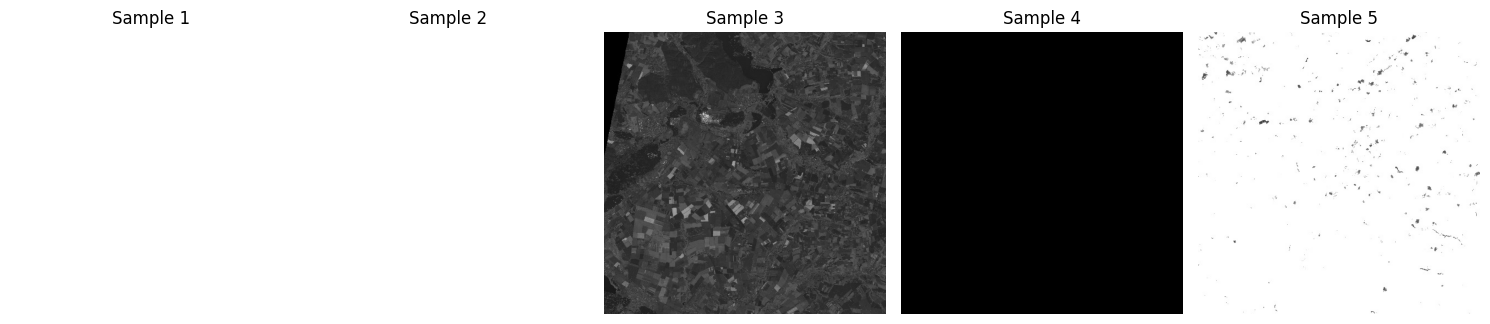

In [39]:
# Visualize 5 random samples from preprocessed dataset
visualize_sample_images(development_dataset_path, num_samples=5)

In [40]:
# Function to reconstruct full image from tiles
def reconstruct_full_image_from_tiles(tile_dir, tile_size=512):
    # Get list of all tiles in the directory
    tile_files = [f for f in os.listdir(tile_dir) if f.endswith('.jpg')]

    # Sort the tile files based on their y and x position in the filename
    tile_files.sort(key=lambda f: (int(f.split('_')[-2]), int(f.split('_')[-1].replace('.jpg', ''))))

    # Extract the max y and x to determine the full image size
    max_y = max(int(f.split('_')[-2]) for f in tile_files)
    max_x = max(int(f.split('_')[-1].replace('.jpg', '')) for f in tile_files)

    # Calculate the size of the full image
    full_height = max_y + tile_size
    full_width = max_x + tile_size

    # Initialize an empty array for the full image
    full_image = np.zeros((full_height, full_width), dtype=np.uint8)

    # Place each tile in its correct position in the full image
    for tile_file in tile_files:
        # Extract y and x from the filename
        y = int(tile_file.split('_')[-2])
        x = int(tile_file.split('_')[-1].replace('.jpg', ''))

        # Load the tile
        tile_path = os.path.join(tile_dir, tile_file)
        tile = cv2.imread(tile_path, cv2.IMREAD_GRAYSCALE)

        # Place the tile in the full image
        full_image[y:y + tile_size, x:x + tile_size] = tile

    return full_image

# Function to visualize the full reconstructed image
def visualize_full_image(image):
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    plt.title("Reconstructed Full Image")
    plt.axis('off')
    plt.show()

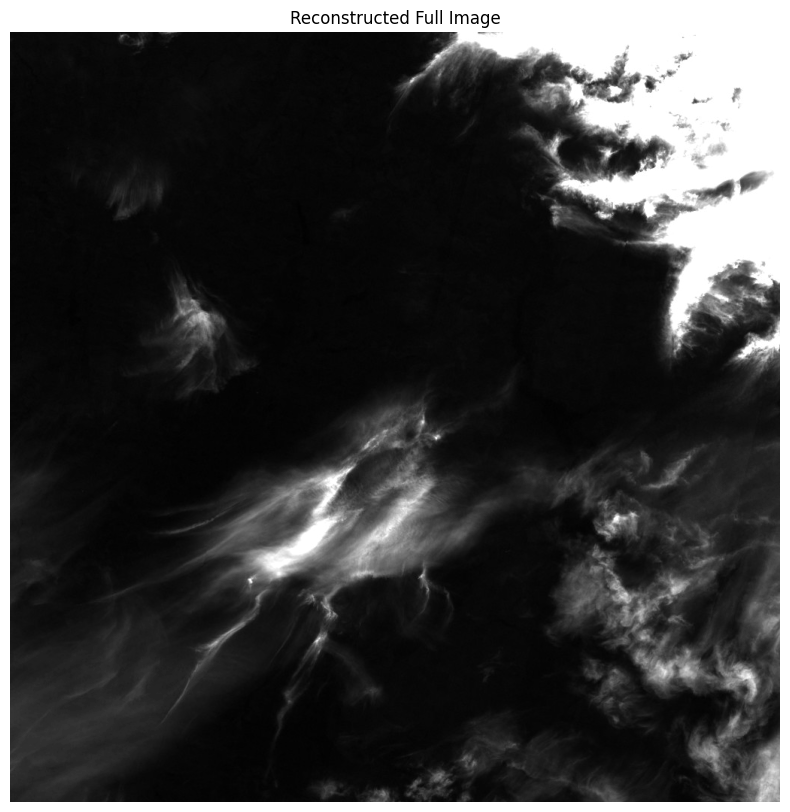

In [42]:
# Reconstruct the full image from the tiles
reconstructed_image = reconstruct_full_image_from_tiles('/content/drive/MyDrive/ Quantum DS Internship/Task 2/Sentinel_dev_data/T36UYA_20190830T083609_B10')
visualize_full_image(reconstructed_image)